In [26]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import NS_model



dim= 3
state_dim = [3,6]
hidden=[16,64,64,16]
range_grid=[[-1,1],[-1,1]]
num_grid=[16,16,16]
dx = (range_grid[0][1]-range_grid[0][0])/num_grid[0]
test_x1 = np.repeat(np.linspace(0,1,1001,endpoint=True).reshape(1001,1),3,axis=1)
test_x1 = torch.tensor(test_x1).float()
test_x1[:,1:]=0.5
test_x2 = np.repeat(np.linspace(0,1,1001,endpoint=True).reshape(1001,1),3,axis=1)
test_x2 = torch.tensor(test_x2).float()
test_x2[:,[0,2]]=0.5
test_x3 = np.repeat(np.linspace(0,1,1001,endpoint=True).reshape(1001,1),3,axis=1)
test_x3 = torch.tensor(test_x3).float()
test_x3[:,[0,1]]=0.5
true_f = lambda u: 0.1*torch.sin(torch.pi*2*(torch.abs(u[:,0])+torch.abs(u[:,1])+torch.abs(u[:,2]))) + 0.1*torch.cos(torch.pi*2*(torch.abs(u[:,0])+torch.abs(u[:,1])+torch.abs(u[:,2])))
para1_mat = np.ndarray((3,50))
para2_mat = np.ndarray((3,50))
nonpara1_mat = np.ndarray((1001,50))
nonpara2_mat = np.ndarray((1001,50))
nonpara3_mat = np.ndarray((1001,50))
u_mat = np.ndarray((1,50))
for i in range(50):
    checkpoints = torch.load('checkpoint/ckpt_ns_64_16_25_0.500_%d.pth'%(i))
    model_net = NS_model.NonParametricModel(dx=dx,state_dim=state_dim,hidden=hidden)
    model_net.net1.load_state_dict(checkpoints['net1'])
    para1_mat[:,i] = checkpoints['D_1'].to('cpu').detach().numpy()
    para2_mat[:,i] = checkpoints['D_2'].to('cpu').detach().numpy()
    model_net = NS_model.NonParametricModel(dx=dx,state_dim=state_dim,hidden=hidden)
    non_out1 = model_net.net1(test_x1)
    nonpara1_mat[:,i] = (non_out1[:,0].reshape(-1).detach() - true_f(test_x1)).to('cpu').numpy()
    non_out2 = model_net.net1(test_x2)
    nonpara2_mat[:,i] = (non_out2[:,1].reshape(-1).detach() - true_f(test_x2)).to('cpu').numpy()
    non_out3 = model_net.net1(test_x3)
    nonpara3_mat[:,i] = (non_out3[:,2].reshape(-1).detach() - true_f(test_x3)).to('cpu').numpy()
    u_mat[:,i] = checkpoints['u_loss']
    
bias1 = (np.mean(para1_mat,axis=1) - [3e-3,4e-3,5e-3])
std1 = np.sqrt(np.mean(np.square(para1_mat - np.mean(para1_mat,axis=1,keepdims=True)),axis=1))
mse1 = np.sqrt(bias1**2 + std1**2)
bias2 = (np.mean(para2_mat,axis=1) - [6e-3,7e-3,8e-3])
std2 = np.sqrt(np.mean(np.square(para2_mat - np.mean(para2_mat,axis=1,keepdims=True)),axis=1))
mse2 = np.sqrt(bias2**2 + std2**2)
mse = np.sqrt(np.sum(mse1**2+mse2**2))
bias1_non = np.sqrt(np.mean(np.square(np.mean(nonpara1_mat,axis=1))))
std1_non = np.sqrt(np.mean(np.square(nonpara1_mat -np.mean(nonpara1_mat,axis=1,keepdims=True))))
rmse1_non = np.sqrt(bias1_non**2 + std1_non**2)
bias2_non = np.sqrt(np.mean(np.square(np.mean(nonpara2_mat,axis=1))))
std2_non = np.sqrt(np.mean(np.square(nonpara2_mat -np.mean(nonpara2_mat,axis=1,keepdims=True))))
rmse2_non = np.sqrt(bias2_non**2 + std2_non**2)
bias3_non = np.sqrt(np.mean(np.square(np.mean(nonpara3_mat,axis=1))))
std3_non = np.sqrt(np.mean(np.square(nonpara3_mat -np.mean(nonpara3_mat,axis=1,keepdims=True))))
rmse3_non = np.sqrt(bias3_non**2 + std3_non**2)
rmse_u = np.sqrt(np.mean(u_mat,axis=1))
print('bias for D1: %.5fe-5, %.5fe-5, %.5fe-5'%(bias1[0]*1e5,bias1[1]*1e5,bias1[2]*1e5))
print('bias for D2: %.5fe-5, %.5fe-5, %.5fe-5'%(bias2[0]*1e5,bias2[1]*1e5,bias2[2]*1e5))
print('std for D1: %.5fe-5, %.5fe-5, %.5fe-5'%(std1[0]*1e5,std1[1]*1e5,std1[2]*1e5))
print('std for D2: %.5fe-5, %.5fe-5, %.5fe-5'%(std2[0]*1e5,std2[1]*1e5,std2[2]*1e5))
print('rmse for D1: %.5fe-5, %.5fe-5, %.5fe-5'%(mse1[0]*1e5,mse1[1]*1e5,mse1[2]*1e5))
print('rmse for D2: %.5fe-5, %.5fe-5, %.5fe-5'%(mse2[0]*1e5,mse2[1]*1e5,mse2[2]*1e5))
print('rmse for D: %.5fe-5'%(mse*1e5))
print('bias for f with w=-0.5: %.5fe-5'%(bias1_non*1e5))
print('std for f with w=-0.5: %.5fe-5'%(std1_non*1e5))
print('rmse for f with w=-0.5: %.5fe-5'%(rmse1_non*1e5))
print('bias for f with w=0: %.5fe-5'%(bias2_non*1e5))
print('std for f with w=0: %.5fe-5'%(std2_non*1e5))
print('rmse for f with w=0: %.5fe-5'%(rmse2_non*1e5))
print('bias for f with w=0.5: %.5fe-5'%(bias3_non*1e5))
print('std for f with w=0.5: %.5fe-5'%(std3_non*1e5))
print('rmse for f with w=0.5: %.5fe-5'%(rmse3_non*1e5))
print('rmse for u:%.5fe-5'%(rmse_u*1e5))

/tmp/ipykernel_21360/1978691508.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoints = torch.load('checkpoint/ckpt_ns_64_16_25_0.500_%d.pth'%(i))


bias for D1: 311.56127e-5, 299.39204e-5, 295.70017e-5
bias for D2: -292.23735e-5, -276.21894e-5, -296.12345e-5
std for D1: 41.13404e-5, 41.72298e-5, 41.13149e-5
std for D2: 68.13102e-5, 115.68405e-5, 109.79431e-5
rmse for D1: 314.26491e-5, 302.28529e-5, 298.54714e-5
rmse for D2: 300.07417e-5, 299.46569e-5, 315.82256e-5
rmse for D: 747.48734e-5
bias for f with w=-0.5: 10052.25530e-5
std for f with w=-0.5: 15256.23831e-5
rmse for f with w=-0.5: 18270.21193e-5
bias for f with w=0: 9985.78608e-5
std for f with w=0: 14400.79639e-5
rmse for f with w=0: 17524.23637e-5
bias for f with w=0.5: 10140.58385e-5
std for f with w=0.5: 15249.30622e-5
rmse for f with w=0.5: 18313.18599e-5
rmse for u:2008.98148e-5


In [23]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import NS_model
import PINN_model


dim= 3
state_dim = [3,6]
hidden=[16,16]
range_grid=[[-1,1],[-1,1]]
num_grid=[16,16,16]
dx = (range_grid[0][1]-range_grid[0][0])/num_grid[0]
test_x1 = np.repeat(np.linspace(0,1,1001,endpoint=True).reshape(1001,1),3,axis=1)
test_x1 = torch.tensor(test_x1).float()
test_x1[:,1:]=0.5
test_x2 = np.repeat(np.linspace(0,1,1001,endpoint=True).reshape(1001,1),3,axis=1)
test_x2 = torch.tensor(test_x2).float()
test_x2[:,[0,2]]=0.5
test_x3 = np.repeat(np.linspace(0,1,1001,endpoint=True).reshape(1001,1),3,axis=1)
test_x3 = torch.tensor(test_x3).float()
test_x3[:,[0,1]]=0.5
true_f = lambda u: 0.1*torch.sin(torch.pi*2*(torch.abs(u[:,0])+torch.abs(u[:,1])+torch.abs(u[:,2]))) + 0.1*torch.cos(torch.pi*2*(torch.abs(u[:,0])+torch.abs(u[:,1])+torch.abs(u[:,2])))
para1_mat = np.ndarray((3,50))
para2_mat = np.ndarray((3,50))
nonpara1_mat = np.ndarray((1001,50))
nonpara2_mat = np.ndarray((1001,50))
nonpara3_mat = np.ndarray((1001,50))
u_mat = np.ndarray((1,50))
for i in range(50):
    checkpoints = torch.load('checkpoint/ckpt_ns_pinn_64_16_25_0.500_%d.pth'%(i))
    model_net = PINN_model.NSEquation(state_dim=state_dim,hidden=hidden)
    model_net.net1.load_state_dict(checkpoints['PDE_model_net1'])
    para1_mat[:,i] = checkpoints['D_1'].to('cpu').detach().numpy()
    para2_mat[:,i] = checkpoints['D_2'].to('cpu').detach().numpy()
    
    non_out1 = model_net.net1(test_x1)
    nonpara1_mat[:,i] = (non_out1[:,0].reshape(-1).detach() - true_f(test_x1)).to('cpu').numpy()
    non_out2 = model_net.net1(test_x2)
    nonpara2_mat[:,i] = (non_out2[:,1].reshape(-1).detach() - true_f(test_x2)).to('cpu').numpy()
    non_out3 = model_net.net1(test_x3)
    nonpara3_mat[:,i] = (non_out3[:,2].reshape(-1).detach() - true_f(test_x3)).to('cpu').numpy()
    u_mat[:,i] = checkpoints['u_loss']
    
bias1 = (np.mean(para1_mat,axis=1) - [3e-3,4e-3,5e-3])
std1 = np.sqrt(np.mean(np.square(para1_mat - np.mean(para1_mat,axis=1,keepdims=True)),axis=1))
mse1 = np.sqrt(bias1**2 + std1**2)
bias2 = (np.mean(para2_mat,axis=1) - [6e-3,7e-3,8e-3])
std2 = np.sqrt(np.mean(np.square(para2_mat - np.mean(para2_mat,axis=1,keepdims=True)),axis=1))
mse2 = np.sqrt(bias2**2 + std2**2)
mse = np.sqrt(np.sum(mse1**2+mse2**2))
bias1_non = np.sqrt(np.mean(np.square(np.mean(nonpara1_mat,axis=1))))
std1_non = np.sqrt(np.mean(np.square(nonpara1_mat -np.mean(nonpara1_mat,axis=1,keepdims=True))))
rmse1_non = np.sqrt(bias1_non**2 + std1_non**2)
bias2_non = np.sqrt(np.mean(np.square(np.mean(nonpara2_mat,axis=1))))
std2_non = np.sqrt(np.mean(np.square(nonpara2_mat -np.mean(nonpara2_mat,axis=1,keepdims=True))))
rmse2_non = np.sqrt(bias2_non**2 + std2_non**2)
bias3_non = np.sqrt(np.mean(np.square(np.mean(nonpara3_mat,axis=1))))
std3_non = np.sqrt(np.mean(np.square(nonpara3_mat -np.mean(nonpara3_mat,axis=1,keepdims=True))))
rmse3_non = np.sqrt(bias3_non**2 + std3_non**2)
rmse_u = np.sqrt(np.mean(u_mat,axis=1))
print('bias for D1: %.5fe-5, %.5fe-5, %.5fe-5'%(bias1[0]*1e5,bias1[1]*1e5,bias1[2]*1e5))
print('bias for D2: %.5fe-5, %.5fe-5, %.5fe-5'%(bias2[0]*1e5,bias2[1]*1e5,bias2[2]*1e5))
print('std for D1: %.5fe-5, %.5fe-5, %.5fe-5'%(std1[0]*1e5,std1[1]*1e5,std1[2]*1e5))
print('std for D2: %.5fe-5, %.5fe-5, %.5fe-5'%(std2[0]*1e5,std2[1]*1e5,std2[2]*1e5))
print('rmse for D1: %.5fe-5, %.5fe-5, %.5fe-5'%(mse1[0]*1e5,mse1[1]*1e5,mse1[2]*1e5))
print('rmse for D2: %.5fe-5, %.5fe-5, %.5fe-5'%(mse2[0]*1e5,mse2[1]*1e5,mse2[2]*1e5))
print('rmse for D: %.5fe-5'%(mse*1e5))
print('bias for f with w=-0.5: %.5fe-5'%(bias1_non*1e5))
print('std for f with w=-0.5: %.5fe-5'%(std1_non*1e5))
print('rmse for f with w=-0.5: %.5fe-5'%(rmse1_non*1e5))
print('bias for f with w=0: %.5fe-5'%(bias2_non*1e5))
print('std for f with w=0: %.5fe-5'%(std2_non*1e5))
print('rmse for f with w=0: %.5fe-5'%(rmse2_non*1e5))
print('bias for f with w=0.5: %.5fe-5'%(bias3_non*1e5))
print('std for f with w=0.5: %.5fe-5'%(std3_non*1e5))
print('rmse for f with w=0.5: %.5fe-5'%(rmse3_non*1e5))
print('rmse for u:%.5fe-5'%(rmse_u*1e5))

/tmp/ipykernel_21360/1284001174.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoints = torch.load('checkpoint/ckpt_ns_pinn_64_16_25_0.500_%d.pth'%(i))


bias for D1: -573.64361e-5, -441.45709e-5, -538.74991e-5
bias for D2: -480.15354e-5, -562.36910e-5, -716.43037e-5
std for D1: 552.81017e-5, 337.71859e-5, 439.34980e-5
std for D2: 236.91080e-5, 290.83318e-5, 383.95875e-5
rmse for D1: 796.65932e-5, 555.82210e-5, 695.18322e-5
rmse for D2: 535.41960e-5, 633.12159e-5, 812.83258e-5
rmse for D: 1665.86251e-5
bias for f with w=-0.5: 15484.04956e-5
std for f with w=-0.5: 62251.48047e-5
rmse for f with w=-0.5: 64148.28611e-5
bias for f with w=0: 42963.11068e-5
std for f with w=0: 61209.08952e-5
rmse for f with w=0: 74782.22729e-5
bias for f with w=0.5: 15343.67086e-5
std for f with w=0.5: 57457.95794e-5
rmse for f with w=0.5: 59471.38106e-5
rmse for u:16696.63406e-5


In [20]:
checkpoints = torch.load('checkpoint/ckpt_ns2_pinn_64_16_25_0.100_%d.pth'%(1))
print(checkpoints)

{'solution_net': OrderedDict([('net.0linear.weight', tensor([[-4.9599e-02, -2.1922e-01, -6.2791e-02,  1.3591e-02],
        [ 1.8317e-01, -7.3960e-01,  6.5909e-02,  5.3751e-04],
        [ 1.7975e-02,  7.3585e-02, -3.3381e-01, -2.7015e-01],
        [ 8.6255e-02,  1.6225e-01,  2.0434e-01,  5.5804e-01],
        [-3.6370e-02, -2.3752e-01,  1.4554e-01, -1.2669e-01],
        [-4.9860e-02, -3.5385e-01,  2.2606e-01,  1.9610e-01],
        [-9.3398e-02, -6.6437e-02, -3.1143e-02, -3.4867e-01],
        [ 2.8574e-01, -3.5684e-01, -4.5754e-01, -8.1553e-01],
        [-3.1913e-01, -9.6129e-01, -2.4181e-01,  1.9537e-01],
        [-4.5904e-02, -7.6395e-02, -5.6709e-02, -4.6749e-01],
        [-6.1154e-01, -3.9131e-01, -2.1876e-01,  4.4699e-01],
        [ 5.0676e-03, -9.5995e-02, -4.7209e-02,  1.8037e-01],
        [-1.2886e-02, -2.8113e-01,  8.4156e-01,  2.6858e-01],
        [ 5.1137e-03,  4.2664e-02, -5.9711e-01, -5.2832e-01],
        [ 8.9389e-02,  2.1292e-01,  6.0722e-01,  2.8594e-02],
        [ 1.8759e

/tmp/ipykernel_21360/3327995378.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoints = torch.load('checkpoint/ckpt_ns2_pinn_64_16_25_0.100_%d.pth'%(1))


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch

u_mat = np.ndarray((1,50))
for i in range(50):
    checkpoints = torch.load('checkpoint/ckpt_ns2_nonpara_64_16_25_0.500_%d.pth'%(i))
    u_mat[:,i] = checkpoints['u_loss']
    
rmse_u = np.sqrt(np.mean(u_mat,axis=1))
print('rmse for u:%.5fe-5'%(rmse_u*1e5))

rmse for u:12957.07861e-5


/tmp/ipykernel_125077/548025285.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoints = torch.load('checkpoint/ckpt_ns2_nonpara_64_16_25_0.500_%d.pth'%(i))


/tmp/ipykernel_1667829/2191496504.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(para1_mat[1,:]-4e-3,hist=False)


<Axes: ylabel='Density'>

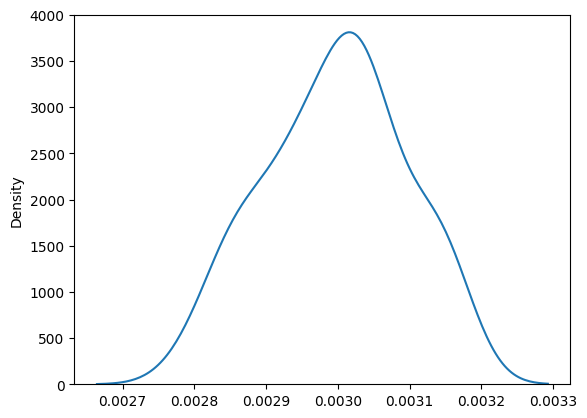

In [4]:
import seaborn as sns
sns.distplot(para1_mat[1,:]-4e-3,hist=False)

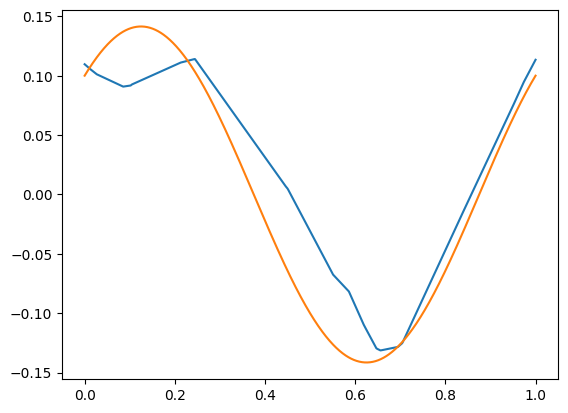

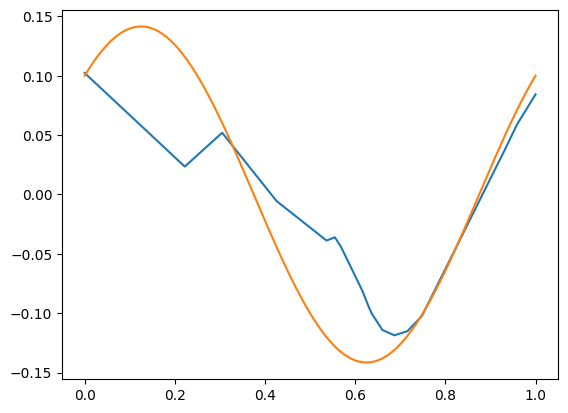

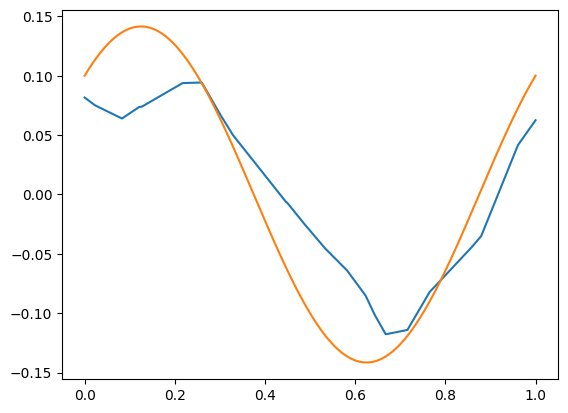

In [2]:
plt.plot(test_x1[:,0],non_out1[:,0].reshape(-1).detach(),test_x1[:,0],true_f(test_x1))
plt.show()
plt.plot(test_x2[:,1],non_out2[:,1].reshape(-1).detach(),test_x2[:,1],true_f(test_x2))
plt.show()
plt.plot(test_x3[:,2],non_out3[:,2].reshape(-1).detach(),test_x3[:,2],true_f(test_x3))
plt.show()

In [16]:
test_x1

tensor([[0.0000, 0.5000, 0.5000],
        [0.0010, 0.5000, 0.5000],
        [0.0020, 0.5000, 0.5000],
        ...,
        [0.9980, 0.5000, 0.5000],
        [0.9990, 0.5000, 0.5000],
        [1.0000, 0.5000, 0.5000]])